In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:


def load_mnist():
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    return mnist_train

def sample_mnist(dataset, num_samples=1000):
    """Ensure uniform class distribution in sampled data."""
    num_classes = 10
    samples_per_class = num_samples // num_classes
    selected_indices = []
    
    for digit in range(num_classes):
        indices = np.where(dataset.targets == digit)[0]
        selected_indices.extend(np.random.choice(indices, samples_per_class, replace=False))
    
    selected_data = dataset.data[selected_indices].float() / 255.0  # Normalize
    selected_labels = dataset.targets[selected_indices]
    
    return selected_data.view(num_samples, -1), selected_labels

def pca(X, num_components):
    """Perform PCA from scratch."""
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    
    covariance_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    principal_components = eigenvectors[:, :num_components]
    X_projected = np.dot(X_centered, principal_components)
    
    return X_projected, principal_components, X_mean, eigenvalues

def reconstruct(X_projected, principal_components, X_mean):
    """Reconstruct data from PCA projections."""
    return np.dot(X_projected, principal_components.T) + X_mean



In [3]:
# Load and Sample MNIST
dataset = load_mnist()
X, y = sample_mnist(dataset)

# Convert to numpy
X = X.numpy()

# Apply PCA for different dimensions
dimensions = [500, 300, 150, 30]
pca_results = {}

for dim in dimensions:
    X_projected, pcs, X_mean, eigvals = pca(X, dim)
    pca_results[dim] = (X_projected, pcs, X_mean, eigvals)

print("PCA implementation completed.")

print(pca_results)

PCA implementation completed.
{500: (array([[-4.53874916e+00,  3.03699679e-01,  7.42029410e-02, ...,
         1.38372836e-02, -5.79813083e-03,  9.63640396e-03],
       [-5.52939853e+00, -2.64083285e-01, -5.14914686e-01, ...,
         9.40627671e-03,  7.12708821e-04, -1.18636653e-02],
       [-1.37901781e+00, -4.48659660e-01,  2.90497849e-01, ...,
        -1.34826616e-02,  9.08095817e-03,  4.19122450e-03],
       ...,
       [ 3.34056884e-01,  3.62201269e+00,  1.82951590e+00, ...,
         3.80688681e-03, -1.75522859e-03,  1.54953905e-02],
       [ 1.88219047e+00,  1.48518061e+00,  1.03170170e+00, ...,
        -1.04584762e-02,  2.26599399e-02,  1.10552586e-02],
       [ 1.63806807e+00,  3.12712781e+00,  5.25866045e-01, ...,
         5.76525037e-03,  1.70940518e-02, -1.46416391e-03]],
      shape=(1000, 500)), array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 

### Plot explained variance

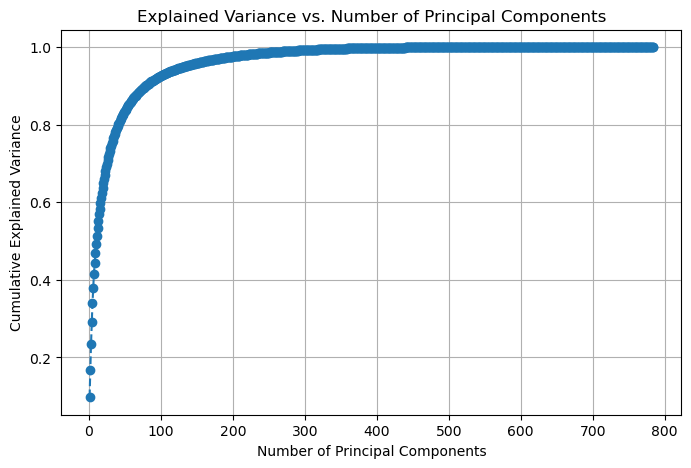

In [4]:


plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigvals) + 1), np.cumsum(eigvals) / np.sum(eigvals), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid()
plt.show()





### Visualize first 2 principal components
haha

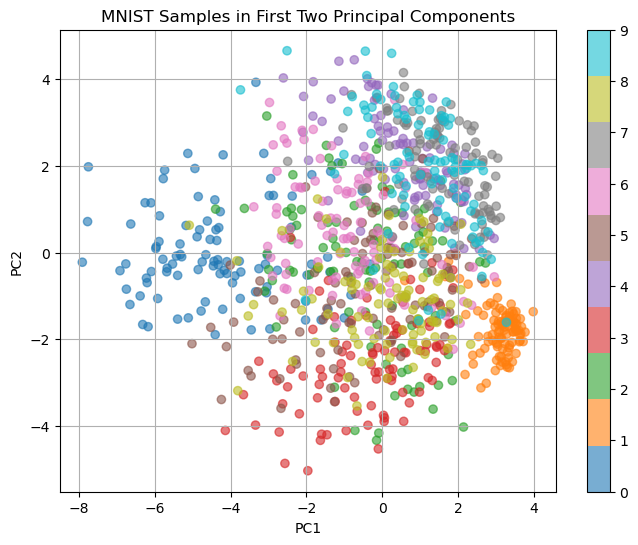

In [5]:

X_2D, _, _, _ = pca(X, 2)
plt.figure(figsize=(8, 6))
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y, cmap='tab10', alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('MNIST Samples in First Two Principal Components')
plt.colorbar()
plt.grid()
plt.show()


## Interpretation:  
Some digits (like 3 and 8) appear clustered together, indicating similarity and some overlap occurs because PCA captures only linear variance.  
PCA is effective in separaating different digits to some extent however, reducing to just two dimensions leads to some information loss.  
Higher dimensions preserve more variance, leading to better separability.  

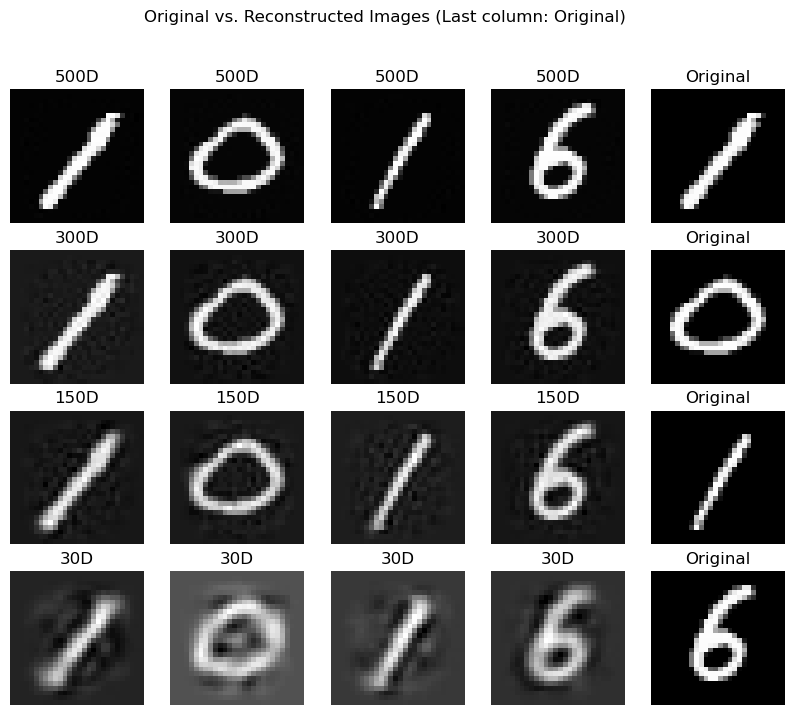

Lossy reconstruction completed.


In [6]:
# Lossy Reconstruction
fig, axes = plt.subplots(len(dimensions), 5, figsize=(10, 8))
selected_indices = np.random.choice(len(X), 4, replace=False)

for i, dim in enumerate(dimensions):
    X_projected, pcs, X_mean, _ = pca_results[dim]
    X_reconstructed = reconstruct(X_projected, pcs, X_mean)
    
    for j, idx in enumerate(selected_indices):
        axes[i, j].imshow(X_reconstructed[idx].reshape(28, 28), cmap='gray')
        axes[i, j].axis('off')
        axes[i, j].set_title(f"{dim}D")
    
    axes[i, 4].imshow(X[selected_indices[i]].reshape(28, 28), cmap='gray')
    axes[i, 4].axis('off')
    axes[i, 4].set_title("Original")

plt.suptitle("Original vs. Reconstructed Images (Last column: Original)")
plt.show()

### Obsservation
The images get more blurry due to information loss because with lower dimensions wthere is leser variance

# MLP

In [7]:
def load_mnist_2():
    transform = transforms.Compose([transforms.ToTensor()])
    mnist_train = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
    mnist_test = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)
    return mnist_train, mnist_test

def sample_mnist_2(dataset, num_samples=40000):
    indices = np.random.choice(len(dataset.data), num_samples, replace=False)
    selected_data = dataset.data[indices].float() / 255.0  # Normalize
    selected_labels = dataset.targets[indices]
    return selected_data.view(num_samples, -1), selected_labels

def train_mlp(X_train, y_train, X_test, y_test):
    clf = MLPClassifier(hidden_layer_sizes=(128, 64), max_iter=50, solver='adam', random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    return accuracy, precision, recall

# Load MNIST
dataset_train, dataset_test = load_mnist_2()
X_train, y_train = sample_mnist_2(dataset_train)
X_test, y_test = dataset_test.data.float().view(len(dataset_test.data), -1) / 255.0, dataset_test.targets

# Convert to numpy
X_train, y_train, X_test, y_test = X_train.numpy(), y_train.numpy(), X_test.numpy(), y_test.numpy()

# Train MLP on raw data
acc_raw, prec_raw, rec_raw = train_mlp(X_train, y_train, X_test, y_test)
print(f"Raw Data -> Accuracy: {acc_raw:.4f}, Precision: {prec_raw:.4f}, Recall: {rec_raw:.4f}")

# Train MLP after PCA transformation
dimensions = [500, 300, 150, 30]
for dim in dimensions:
    X_train_pca, pcs, X_mean, _ = pca(X_train, dim)
    X_test_pca = np.dot(X_test - X_mean, pcs)
    acc, prec, rec = train_mlp(X_train_pca, y_train, X_test_pca, y_test)
    print(f"PCA {dim}D -> Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")

print("DONE")


Raw Data -> Accuracy: 0.9776, Precision: 0.9776, Recall: 0.9773
PCA 500D -> Accuracy: 0.9706, Precision: 0.9704, Recall: 0.9704
PCA 300D -> Accuracy: 0.9725, Precision: 0.9723, Recall: 0.9723
PCA 150D -> Accuracy: 0.9753, Precision: 0.9752, Recall: 0.9749
PCA 30D -> Accuracy: 0.9783, Precision: 0.9782, Recall: 0.9781
Classification performance evaluation completed.


/usr/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


### Observations
There is not much difference in the quality metrics even after reducing the dimensions. - even 30D wirks almost as well as the original  
This shows that PCA eliminates the noise and redundant features and forces the mlp to learn the important features.  
Therefore PCA is good your health